# Analysis of epistasis in Kd datasets

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import re
from pathlib import Path
from sklearn.metrics import roc_auc_score
import matplotlib as mpl
from pathlib import Path

import sys
sys.path.append("../")
from utils import *
from global_variables import *
import matplotlib as mpl

mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.0,
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})


E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors
Loaded 438 KD vectors


In [2]:
len(WT)

178

## Desai data

## Comparing model predictions

In [3]:


files = [
    "cleaned_Kds_RBD_CB6_proper.csv",
    "cleaned_Kds_RBD_CoV555_proper.csv",
    "cleaned_Kds_RBD_REGN10987_proper.csv",
    "cleaned_Kds_RBD_S309_proper.csv",
    "cleaned_Kds_RBD_ACE2.csv"
]
names = [f.split("_RBD_")[1].split("_")[0] for f in files]  # ['CB6','CoV555','REGN10987','S309']
seq='NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'
assert isinstance(seq, str) and len(seq) > 0, "Define `seq` as the WT RBD sequence starting at residue 331."

# Mutations in bit order
bit_mutations = [
    "G339D",#    "G339D" not sued as outside limit of model

    "S371L","S373P","S375F","K417N",
    "N440K","G446S","S477N","T478K","E484A",
    "Q493R","G496S","Q498R","N501Y","Y505H",
]

# --- Helpers ---
def parse_mut(m):
    m = m.strip()
    m = re.fullmatch(r"([ACDEFGHIKLMNPQRSTVWY])(\d{3})([ACDEFGHIKLMNPQRSTVWY])", m)
    if not m:
        raise ValueError(f"Bad mutation code: {m}")
    wt, pos, mt = m.group(1), int(m.group(2)), m.group(3)
    return wt, pos, mt

parsed = [parse_mut(m) for m in bit_mutations]

# Assert WT letters match provided seq
start_res = 331
for wt, pos, mt in parsed:
    idx = pos - start_res
    assert 0 <= idx < len(seq), f"Position {pos} out of range for seq of len {len(seq)} starting at {start_res}"
    assert seq[idx] == wt, f"WT mismatch at {pos}: expected {wt}, found {seq[idx]}"

def geno_to_array(series, L=15):
    s = series.astype(str).str.strip().str.replace(r"\s+", "", regex=True)
    s = s.str.zfill(L)
    bad = ~s.str.fullmatch(f"[01]{{{L}}}")
    if bad.any():
        print(f"[WARN] dropping {bad.sum()} rows with invalid geno")
    s = s[~bad]
    X = np.vstack([np.frombuffer(g.encode("utf-8"), dtype="S1").astype(int) for g in s])
    return X, s.index.to_numpy(), s

def apply_geno(seq_wt, geno_bits, parsed_mutations, start_res=331):
    s = list(seq_wt)
    muts_applied = []
    for bit, (wt, pos, mt) in zip(geno_bits, parsed_mutations):
        if bit == 1:
            idx = pos - start_res
            assert s[idx] == wt, f"WT mismatch at {pos}: expected {wt}, found {s[idx]}"
            s[idx] = mt
            muts_applied.append(f"{wt}{pos}{mt}")
    return "".join(s), muts_applied



In [4]:
base = Path("../exp_data/desai_data")
ab_names = list(KD_VECTORS.keys())  # order us

In [5]:

names=['CB6', 'CoV555', 'REGN10987']
name_ab_mapping={'CB6': 'LY-CoV016', 'CoV555': 'LY-CoV555', 'REGN10987':'REGN10987'}



(32768, 201)
(32768, 201)
(32768, 201)


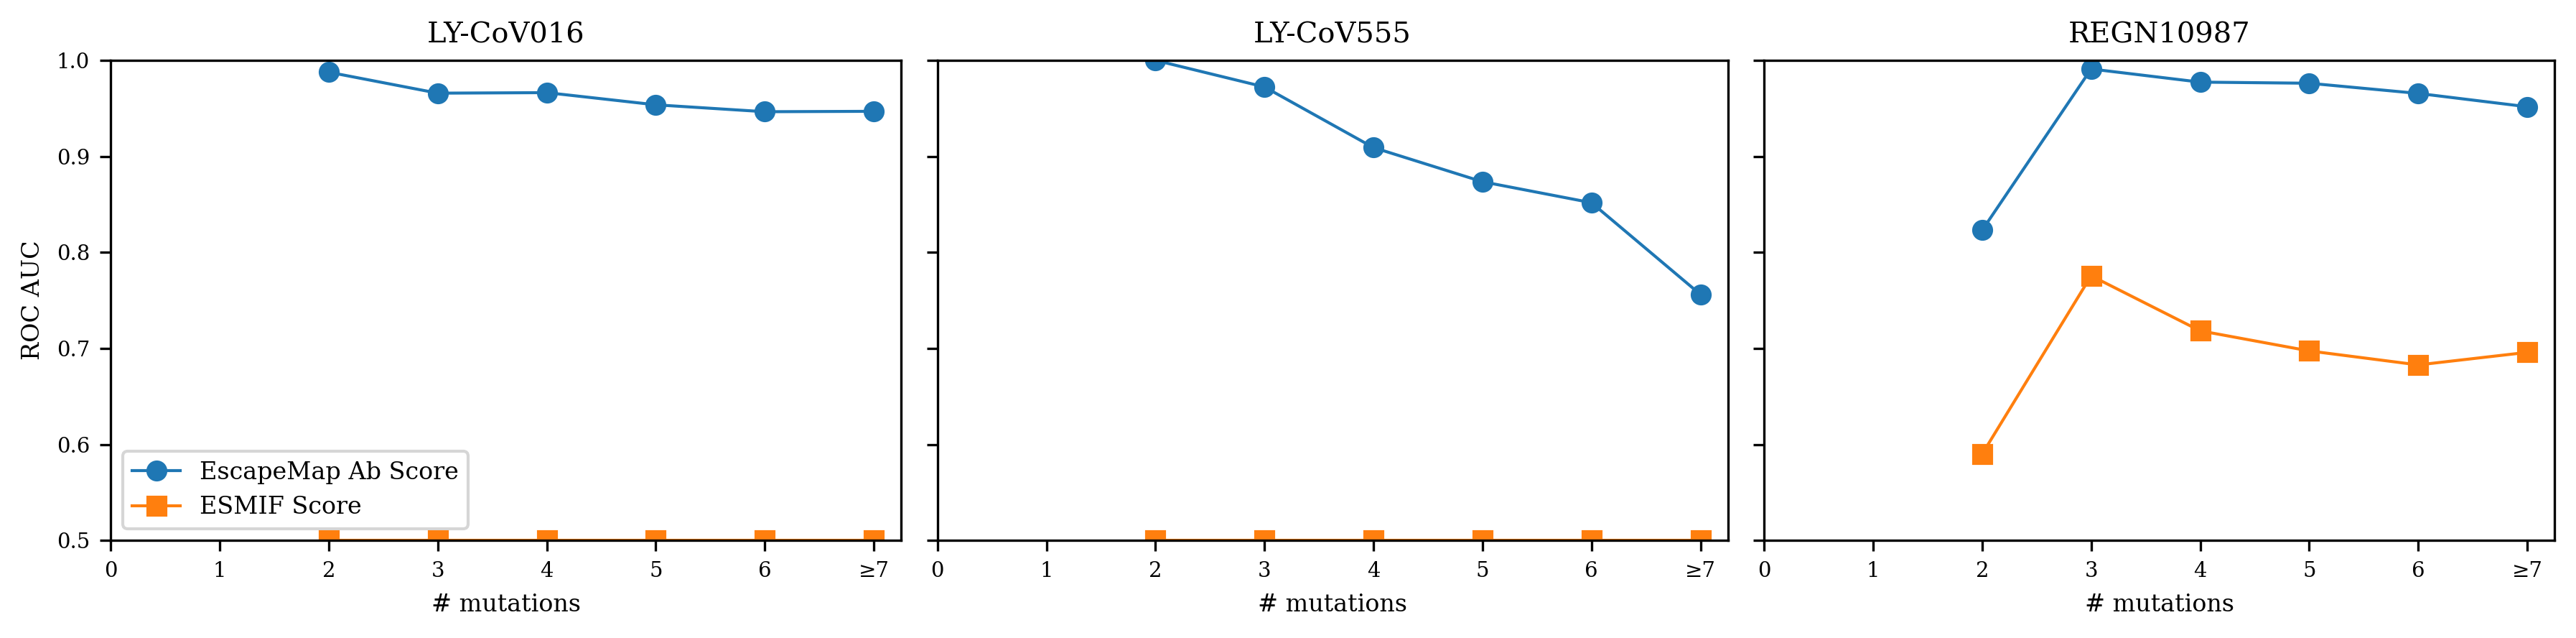

In [6]:


all_bins = np.arange(0, 8) 
auc_kd = {}
auc_esmif = {}
bin_counts = {}

for i, name in enumerate(names):
    f="cleaned_Kds_RBD_"+name+"_proper.csv"
    exp_data = pd.read_csv(base / f)
    f_esmif="desai_"+name+"_esmif_clean.csv"
    esmif_data= pd.read_csv(base / f_esmif)
    exp_data['esmif']=esmif_data['log_likelihood']

    X, kept_idx, s_clean = geno_to_array(exp_data["geno"], L=15)
    drop_on_firstbit = (X[:, 0] == 1)
    remove_mask = np.zeros(len(exp_data), dtype=bool)
    remove_mask[kept_idx] = drop_on_firstbit

    fasta_path = base / f"ACE2.fasta"
    seqs = Proteins_utils.load_FASTA(fasta_path)
    print(seqs.shape)
    
    seq_keep_mask = ~(remove_mask[kept_idx])
    exp_filtered = exp_data.iloc[kept_idx].loc[seq_keep_mask].reset_index(drop=True)
    seqs_filtered = seqs[seq_keep_mask][:, BEGIN:-END]
    mut_counts_raw = X.sum(axis=1)[seq_keep_mask].astype(int)

    # group >6 mutations into one bin labeled as 7 (meaning ≥7)
    mut_counts = np.where(mut_counts_raw > 6, 7, mut_counts_raw).astype(int)

    predicted_kds = np.array([get_Kd(seq, KD_VECTORS) for seq in seqs_filtered])

    ab_label = name_ab_mapping[name]
    ab_idx = ab_names.index(ab_label)
    kd_pred_ab = predicted_kds[:, ab_idx]

    # --- NEW: AUC by mutation count (label: log10Kd <= 5) ---
    y_cont = exp_filtered['log10Kd'].astype(float).fillna(5.0).to_numpy()

    y_label = np.isfinite(y_cont) & (y_cont <= 5)
    y_label = y_label.astype(int)

    esmif_scores = -exp_filtered['esmif'].to_numpy()

    aucs_kd = np.full(8, np.nan, dtype=float)
    aucs_esm = np.full(8, np.nan, dtype=float)
    cnts = np.zeros(8, dtype=int)

    for j, m in enumerate(all_bins):
        m_mask = (mut_counts == m)

        # ensure finite scores and labels present
        mask_kd = m_mask & np.isfinite(kd_pred_ab) & np.isfinite(y_cont)
        mask_em = m_mask & np.isfinite(esmif_scores) & np.isfinite(y_cont)

        # require both classes to exist in bin
        def _safe_auc(y_true_bin, y_score_bin):
            if np.unique(y_true_bin).size < 2 or y_true_bin.size < 3:
                return np.nan
            try:
                return max(roc_auc_score(y_true_bin, y_score_bin),0.5)
            except Exception:
                return np.nan

        aucs_kd[j]  = _safe_auc(y_label[mask_kd], kd_pred_ab[mask_kd])
        aucs_esm[j] = _safe_auc(y_label[mask_em], esmif_scores[mask_em])

        cnts[j] = int(m_mask.sum())

    auc_kd[name] = aucs_kd
    auc_esmif[name] = aucs_esm
    bin_counts[name] = cnts

# --- Plot: one subplot per antibody, AUC vs. number of mutations ---
fig, axes = plt.subplots(1, len(names), figsize=(4 * len(names), 3), sharey=True)
if len(names) == 1:
    axes = [axes]

xticks = all_bins
xticklabels = ["0", "1", "2", "3", "4", "5", "6", "≥7"]

for ax, name in zip(axes, names):
    ax.plot(xticks, auc_kd[name], marker="o", label="EscapeMap Ab Score")
    ax.plot(xticks, auc_esmif[name], marker="s", label="ESMIF Score")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel("# mutations")
    ax.set_title(name_ab_mapping[name])
    ax.set_ylim(0.5, 1.0)
    ax.grid(False)

axes[0].set_ylabel("ROC AUC")
axes[0].legend(loc="best")
plt.tight_layout()
plt.show()


# ACE2

In [7]:
mlaep_df=pd.read_csv(base / "ACE2_MLAEP.csv", sep=',')
mlaep_df
ace2_csv = "cleaned_Kds_RBD_ACE2_proper.csv"   
desai_df=pd.read_csv(base / ace2_csv, sep=',')
desai_df
L=15
X, kept_idx, s_clean = geno_to_array(desai_df["geno"], L=L)
drop_on_firstbit = (X[:, 0] == 1)
remove_mask = np.zeros(len(exp_data), dtype=bool)
mask_full = np.zeros(len(desai_df), dtype=bool)
mask_full[kept_idx] = drop_on_firstbit  

# Apply to desai_df
desai_df_f = desai_df.loc[~mask_full].reset_index(drop=True)
mlaep_df_f = mlaep_df.loc[~mask_full].reset_index(drop=True)

print("Dropped rows:", int(mask_full.sum()))
print("desai_df_f:", desai_df_f.shape)
print("mlaep_df_f:", mlaep_df_f.shape)
mlaep_values=mlaep_df_f['ACE2'].values
desai_values=desai_df_f['log10Kd'].values



Dropped rows: 16384
desai_df_f: (16384, 46)
mlaep_df_f: (16384, 10)


Spearman ρ = -0.300, p = 0.000e+00


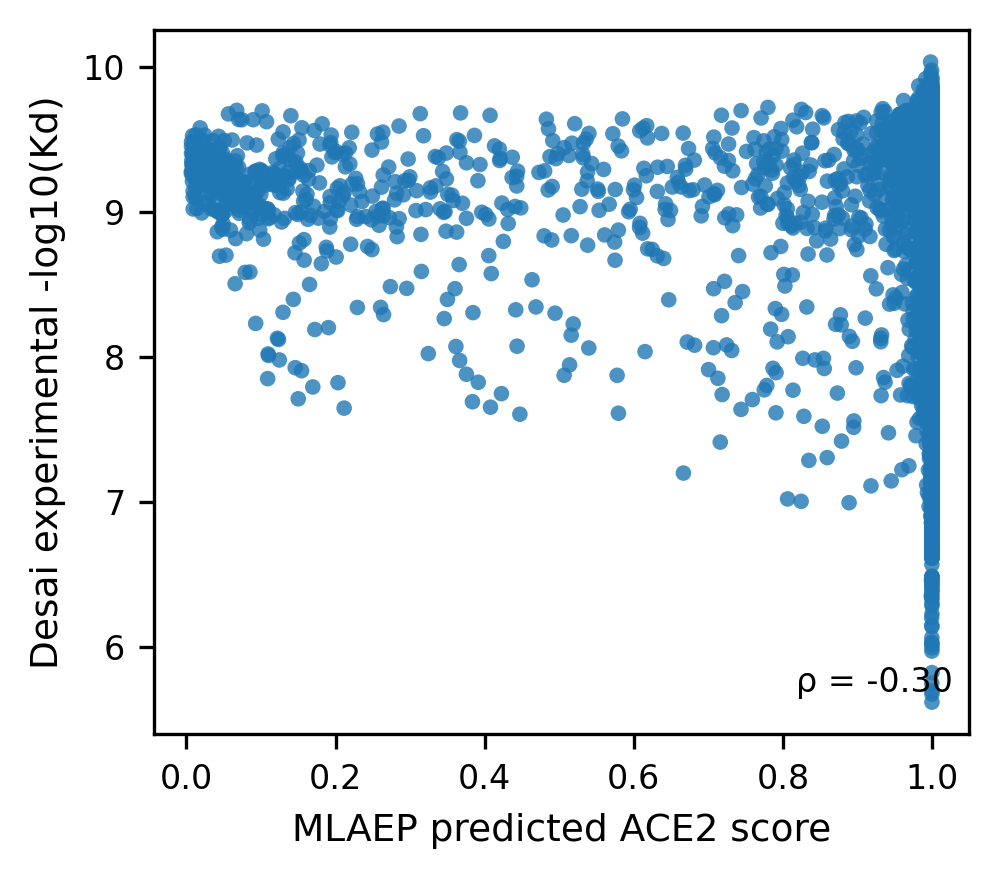

In [8]:




# Ensure numeric and aligned
x = np.asarray(mlaep_values, dtype=float)
y = np.asarray(desai_values, dtype=float)
mask = np.isfinite(x) & np.isfinite(y)
x, y = x[mask], y[mask]

# Spearman correlation
rho, pval = spearmanr(x, y)
print(f"Spearman ρ = {rho:.3f}, p = {pval:.3e}")

mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "font.family": "DejaVu Sans", "font.size": 9,
    "axes.titlesize": 10, "axes.labelsize": 9,
    "xtick.labelsize": 8, "ytick.labelsize": 8,
    "axes.linewidth": 0.8, "xtick.direction": "out", "ytick.direction": "out",
    "xtick.major.width": 0.8, "ytick.major.width": 0.8,
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

# --- Plot ---
fig, ax = plt.subplots(figsize=(3.4, 3.0))

ax.scatter(x, y, s=14, alpha=0.8, edgecolor="none")

# Labels
ax.set_xlabel("MLAEP predicted ACE2 score")
ax.set_ylabel("Desai experimental -log10(Kd)")

# Spearman annotation
ax.text(0.98, 0.05, f"ρ = {rho:.2f}", transform=ax.transAxes,
        ha="right", va="bottom", fontsize=8)


plt.tight_layout()
plt.show()


In [9]:


# ---------------- Config ----------------
base = Path(base)  
L = 15            
ace2_csv = "cleaned_Kds_RBD_ACE2_proper.csv"
esmif_clean_csv = "desai_ACE2_esmif_clean.csv"   # expects columns: geno, log_likelihood (same row order as exp)
mlaep_csv = "ACE2_MLAEP.csv"                     # expects column 'ACE2' (same row order as exp)
fasta_name = "ACE2.fasta"                        # FASTA containing sequences aligned to exp rows



# ---------------- Helpers ----------------
def find_log10kd_col(cols):
    cands = ["log10Kd", "log10KD", "log10_kd", "log10_Kd", "kd_log10", "KD_log10", "Log10Kd"]
    for c in cands:
        if c in cols:
            return c
    for c in cols:
        cl = c.lower()
        if ("kd" in cl) and ("log10" in cl):
            return c
    raise KeyError("No log10Kd column found in experimental CSV.")

def normalize_geno(series, L=15):
    s = series.astype(str).str.strip().str.replace(r"\s+", "", regex=True).str.zfill(L)
    bad = ~s.str.fullmatch(f"[01]{{{L}}}")
    if bad.any():
        print(f"[WARN] dropping {bad.sum()} rows with invalid geno")
    s[bad] = np.nan  # keep alignment; mark invalid as NaN to be dropped later
    return s

def spearman_np(x, y):
    xs = pd.Series(x, dtype="float64")
    ys = pd.Series(y, dtype="float64")
    mask = xs.notna() & ys.notna()
    xs, ys = xs[mask], ys[mask]
    if len(xs) < 2 or xs.nunique() < 2 or ys.nunique() < 2:
        return np.nan
    rx = xs.rank(method="average")
    ry = ys.rank(method="average")
    return float(rx.corr(ry))

# ---------------- Load data ----------------
exp = pd.read_csv(base / ace2_csv)
esmif = pd.read_csv(base / esmif_clean_csv)  # must match exp row order
mlaep = pd.read_csv(base / mlaep_csv)        # must match exp row order

# Basic length sanity checks for index-based assignment (no merges, as requested)
if len(esmif) != len(exp):
    raise ValueError(f"ESM-IF rows ({len(esmif)}) do not match experimental rows ({len(exp)}).")
if "ACE2" not in mlaep.columns:
    raise KeyError("MLAEP CSV must contain an 'ACE2' column.")
if len(mlaep) != len(exp):
    raise ValueError(f"MLAEP rows ({len(mlaep)}) do not match experimental rows ({len(exp)}).")

# Add ESM-IF and MLAEP columns by index (no merge)
exp = exp.copy()
exp["esmif_ll"] = pd.to_numeric(esmif["log_likelihood"], errors="coerce")
exp["mlaep_ace2"] = pd.to_numeric(mlaep["ACE2"], errors="coerce")

exp["geno"] = normalize_geno(exp["geno"], L=L)
log_col = find_log10kd_col(exp.columns)
exp["log10Kd"] = pd.to_numeric(exp[log_col], errors="coerce")

#  filter: drop genos with first bit = '1' 
bad_firstbit = exp["geno"].str[0].eq("1")
keep_mask = (~bad_firstbit) & exp["geno"].notna()

exp_f = exp.loc[keep_mask, ["geno", "log10Kd", "esmif_ll", "mlaep_ace2"]].reset_index(drop=True)


seqs_all = Proteins_utils.load_FASTA(base / fasta_name)
if isinstance(seqs_all, (list, tuple)):
    seqs_all = np.asarray(seqs_all)

if seqs_all.shape[0] == len(exp):
    seqs_filtered = seqs_all[keep_mask.values][:, BEGIN:-END] if END != 0 else seqs_all[keep_mask.values][:, BEGIN:]
elif seqs_all.shape[0] == len(exp_f):
    seqs_filtered = seqs_all[:, BEGIN:-END] if END != 0 else seqs_all[:, BEGIN:]
else:
    raise ValueError(
        f"FASTA length {seqs_all.shape[0]} not compatible with exp {len(exp)} "
        f"or filtered exp_f {len(exp_f)}."
    )

kd_vals = np.asarray([get_Kd(s, ACE2_KD_VECTOR) for s in seqs_filtered]).squeeze()


exp_f["kd_model"] = -pd.to_numeric(kd_vals, errors="coerce")

# ---------------- Mutation bins ----------------
# Count of '1's in geno; bin >6 as 7 (≥7)
exp_f["mut_count_raw"] = exp_f["geno"].str.count("1")
exp_f["mut_bin"] = np.where(exp_f["mut_count_raw"] > 6, 7, exp_f["mut_count_raw"]).astype(int)

# ---------------- Spearman correlations ----------------
overall_rho_esmif = spearman_np(exp_f["esmif_ll"],  exp_f["log10Kd"])
overall_rho_mlaep = spearman_np(exp_f["mlaep_ace2"], exp_f["log10Kd"])
overall_rho_kd    = spearman_np(exp_f["kd_model"],   exp_f["log10Kd"])

rows = []
for m in range(0, 8):  # 0..6; 7 => ≥7
    sub = exp_f[exp_f["mut_bin"] == m]
    rho_esm = spearman_np(sub["esmif_ll"],  sub["log10Kd"])
    rho_mlp = spearman_np(sub["mlaep_ace2"], sub["log10Kd"])
    rho_kdm = spearman_np(sub["kd_model"],   sub["log10Kd"])
    rows.append({
        "mut_bin": m,
        "n": len(sub),
        "rho_esmif":  rho_esm,
        "rho_mlaep":  rho_mlp,
        "rho_kdmod":  rho_kdm,
    })

res = pd.DataFrame(rows).sort_values("mut_bin").reset_index(drop=True)

print("Overall Spearman:")
print(f"  log10Kd vs ESM-IF log-likelihood: {overall_rho_esmif:.3f}")
print(f"  log10Kd vs MLAEP ACE2:            {overall_rho_mlaep:.3f}")
print(f"  log10Kd vs KD model:              {overall_rho_kd:.3f}")
print("\nPer-bin Spearman:")
print(res.to_string(index=False))


Overall Spearman:
  log10Kd vs ESM-IF log-likelihood: -0.012
  log10Kd vs MLAEP ACE2:            -0.300
  log10Kd vs KD model:              0.595

Per-bin Spearman:
 mut_bin    n  rho_esmif  rho_mlaep  rho_kdmod
       0    1        NaN        NaN        NaN
       1   14  -0.182418  -0.389011   0.718681
       2   91  -0.094187  -0.446103   0.766380
       3  364  -0.041780  -0.432651   0.732428
       4 1001   0.016446  -0.412956   0.703223
       5 2002   0.062226  -0.390651   0.676723
       6 3003   0.093731  -0.336469   0.650851
       7 9908   0.056044  -0.262992   0.586336


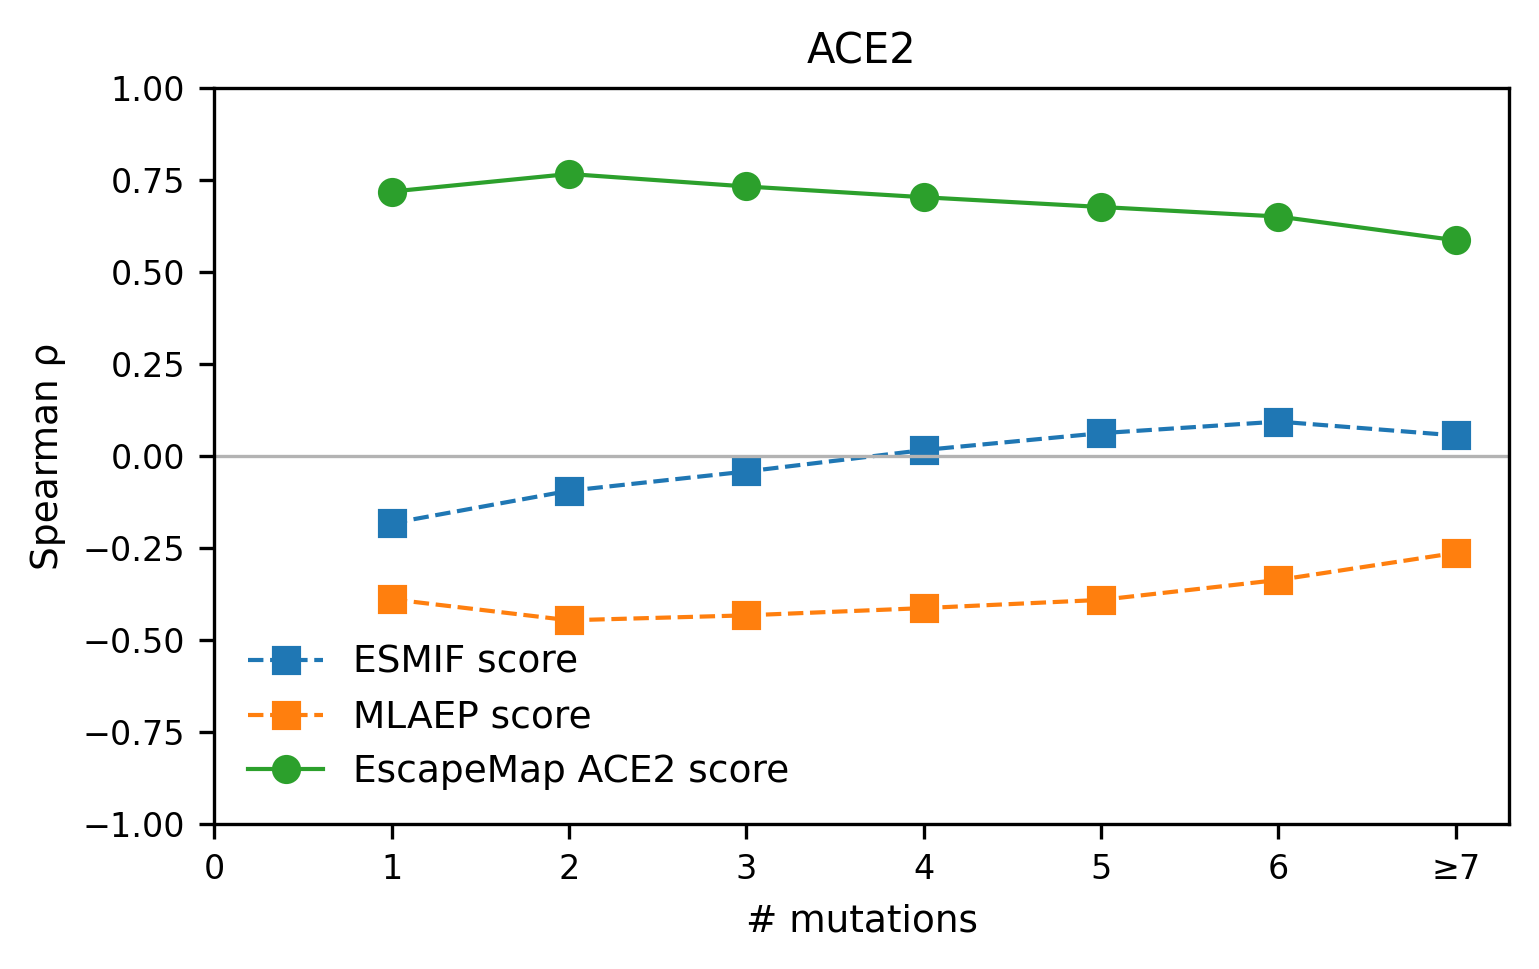

In [10]:
plt.figure(figsize=(5.2, 3.3))
plt.plot(res["mut_bin"], res["rho_esmif"], marker="s", linestyle="--", label="ESMIF score")
plt.plot(res["mut_bin"], res["rho_mlaep"], marker="s", linestyle="--", label="MLAEP score")
plt.plot(res["mut_bin"], res["rho_kdmod"], marker="o", linestyle="-", label="EscapeMap ACE2 score")
plt.axhline(0, color="0.7", lw=0.8)
plt.xlabel("# mutations")
plt.ylabel("Spearman ρ")
plt.xticks(range(0, 8), ["0","1","2","3","4","5","6","≥7"])
plt.ylim(-1.0, 1.0)
plt.title("ACE2")
# for spine in ("top", "right"):
#     plt.gca().spines[spine].set_visible(False)
plt.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()